# M&M Replication for Backcasting any Time Series

In [4]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
import os
import shutil
from scipy.sparse import vstack
import matplotlib.pyplot as plt
from manela import *

# Part 1: Data Preparation

There are a two tasks to accomplish:
    a. Load the timeseries we want to backcast into the correct format
    b. Update the target variable in the testing and training document term matrices

# Note: You likely will have to change some of the code depending on the format of the timeseries you input!!!

# a. Processing Timeseries

In [5]:
# loading the timeseries

# store the path to the timeseries in this variable. If in same directory, use './filename'
path_to_timeseries = './aaii.xlsx'

# If in csv format, use pd.read_csv. If in excel format use pd.read_excel
df = pd.read_excel(path_to_timeseries)
df

,Date,Bullish,Neutral,Bearish
0,1987-07-24,"36,0%","50,0%","14,0%"
1,1987-07-31,"26,0%","48,0%","26,0%"
2,1987-08-07,"56,0%","15,0%","29,0%"
3,1987-08-14,"45,0%","35,0%","20,0%"
4,1987-08-21,"66,0%","28,0%","6,0%"
...,...,...,...,...
1861,2023-04-06,"33,33%","31,65%","35,02%"
1862,2023-04-13,"26,05%","39,46%","34,48%"
1863,2023-04-20,"27,22%","37,66%","35,13%"
1864,2023-04-27,"24,14%","37,36%","38,51%"


In [6]:
# Process one timeseries at a time. 
# If there are multiple target columns in df, only include 'Date' and the one you want to backcast
# You will need to change the name of the columns in the line below to match with the df above
# In this example, I am using the file aaii.xlsx, and I am analyzing the column 'Bearish'

# store the name of the column in the variable target (so you don't have to change it multiple times)
target = 'Neutral'

df = df[['Date', target]]
df

,Date,Neutral
0,1987-07-24,"50,0%"
1,1987-07-31,"48,0%"
2,1987-08-07,"15,0%"
3,1987-08-14,"35,0%"
4,1987-08-21,"28,0%"
...,...,...
1861,2023-04-06,"31,65%"
1862,2023-04-13,"39,46%"
1863,2023-04-20,"37,66%"
1864,2023-04-27,"37,36%"


In [7]:
# Now we need to fix the date column.
# We need a format of YYYYMM (ex: 202306 for June 2023)
# Note: you may need to change the specifics of the fix_date function to do this

def fix_date(x):
    x = pd.to_datetime(x)
    year = x.year
    month = x.month
    if month < 10:
        return str(year) + '0' + str(month)
    else:
        return str(year) + str(month)
    
df['Date'] = df['Date'].apply(lambda x: fix_date(x))
df

/var/folders/n5/2fld4dp113dfbc1h0f87y9_r0000gn/T/ipykernel_50059/1758002920.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(lambda x: fix_date(x))


,Date,Neutral
0,198707,"50,0%"
1,198707,"48,0%"
2,198708,"15,0%"
3,198708,"35,0%"
4,198708,"28,0%"
...,...,...
1861,202304,"31,65%"
1862,202304,"39,46%"
1863,202304,"37,66%"
1864,202304,"37,36%"


In [8]:
# also need to fix the target variable. Pandas loads the variable as type string originally
# desired format is float
# you likely will need to change the specifics of the fix_num function to do this

# !!!note: if the string is already in a float/int format, you don't need to run this cell!!!

# in this example, the input was '14,0%', which needs to become 0.14

def fix_num(x):
    if x != x:
        return np.NaN
    comma_pos = x.index(',')
    x = ''.join(list(filter(str.isdigit, x)))
    if comma_pos == 1:
        x = '0.0' + x
    else:
        x = '0.' + x
    return float(x)

df[target] = df[target].apply(lambda x: fix_num(x))
df

/var/folders/n5/2fld4dp113dfbc1h0f87y9_r0000gn/T/ipykernel_50059/461983009.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].apply(lambda x: fix_num(x))


,Date,Neutral
0,198707,0.5000
1,198707,0.4800
2,198708,0.1500
3,198708,0.3500
4,198708,0.2800
...,...,...
1861,202304,0.3165
1862,202304,0.3946
1863,202304,0.3766
1864,202304,0.3736


In [9]:
# Note: we can only have one value for each month
# you can just take the first/last value using df.drop_duplicates(keep='last')
# if you want to take an average value you can as well

df = df.drop_duplicates(subset='Date', keep='last').reset_index(drop=True)
df

,Date,Neutral
0,198707,0.4800
1,198708,0.1800
2,198709,0.1700
3,198710,0.2300
4,198711,0.4600
...,...,...
426,202301,0.3496
427,202302,0.3976
428,202303,0.3187
429,202304,0.3736


# b. Processing Docmats

In [10]:
# first we need to load the docmats
# there are three files (from Asaf Manela's github)
# TF_predict.txt, TF_test.txt, TF_train.txt
# Note: num_features for this dataset is 468091
# We need to pass this parameter since the three sub-matrices do not all contain each feature

num_features = 468091

# Note: I had to break the predict file into 2 separate parts because the original file was over 100MB
predict1 = datasets.load_svmlight_file('./data/TF_predict_pt1.txt', n_features=num_features)
predict2 = datasets.load_svmlight_file('./data/TF_predict_pt2.txt', n_features=num_features)
test = datasets.load_svmlight_file('./data/TF_test.txt', n_features=num_features)
train = datasets.load_svmlight_file('./data/TF_train.txt', n_features=num_features)

In [11]:
# Note: These docmats have the following dates for the train/test/predict split
# Train: 199601-200912
# Test: 198601-199512 (Note: 199201 is missing)
# Predict 188907-198512 (Note: many months are missing)
# We store which date falls in which docmat in a csv called dates.csv in the data directory
# It is difficult, although possible, to extract this information from the files Asaf provides
# Note 'Period' is either 'Predict', 'Test', 'Train', or NONE 
# if Period is N/A, there is no line in the docmat corresponding to that month

dates = pd.read_csv('./data/dates.csv')
dates

,Date,Period
0,188907,Predict
1,188908,Predict
2,188909,Predict
3,188910,Predict
4,188911,Predict
...,...,...
1441,200908,Train
1442,200909,Train
1443,200910,Train
1444,200911,Train


In [12]:
# first we concatenate the predict1, predict2, test, and train docmats
# !!! it needs to be in this order, because Asaf Manela had test period before train period !!!
# Note: datasets.load_svmlight_file returns a tuple with two objects
# the first is the sparse docmat, and the second is the target variable (in an array)

docmat = vstack([predict1[0], predict2[0], test[0], train[0]])
docmat

<1439x468091 sparse matrix of type '<class 'numpy.float64'>'
	with 10190486 stored elements in Compressed Sparse Row format>

In [13]:
# Current Goal: we want to save the docmat with our train/test split
# And also with our target variable, with the dates aligned
# First: save the cutoffs for the train/test split here:
# We assume the predict period comes before both the train and test periods
# Note: we can only consider dates <= 200912 with this docmat
# Also: the train and test periods need to lie completely after the start of the timeseries

# start of the timeseries is stored in int(df.Date.values[0])
train_start = int(df.Date.values[0])
train_end = 199912
test_start = 200001
test_end = 200912

In [14]:
# Adjusting the dates df to reflect our new choice of cutoffs

def change_date(x):
    # need to keep n/a if the original Period was n/a
    if x.Period != x.Period:
        return np.NaN
    date = int(x.Date)
    if date >= train_start and date <= train_end:
        return 'Train'
    elif date >= test_start and date <= test_end:
        return 'Test'
    else:
        return 'Predict'
    
dates['Period'] = dates.apply(lambda x: change_date(x), axis=1)
dates

,Date,Period
0,188907,Predict
1,188908,Predict
2,188909,Predict
3,188910,Predict
4,188911,Predict
...,...,...
1441,200908,Test
1442,200909,Test
1443,200910,Test
1444,200911,Test


In [15]:
# now we can add the value of the timeseries to the dates df using the get_target function

def get_target(x):
    if str(x) not in df['Date'].tolist():
        # for svmlight, we want to have a value of 0 for the predict period
        # this is because a target variable of all 0's allows for a prediction to be made
        return 0
    else:
        return df[df['Date'] == str(x)][target].values[0]
    
dates[target] = dates['Date'].apply(lambda x: get_target(x))
dates

,Date,Period,Neutral
0,188907,Predict,0.0000
1,188908,Predict,0.0000
2,188909,Predict,0.0000
3,188910,Predict,0.0000
4,188911,Predict,0.0000
...,...,...,...
1441,200908,Test,0.1748
1442,200909,Test,0.1636
1443,200910,Test,0.2404
1444,200911,Test,0.1666


In [16]:
# now we need to dropna in the Period column
# This is so that the dates df corresponds 1:1 with the rows of the docmat

dates = dates[dates['Period'].notna()]
dates = dates.reset_index(drop=True).reset_index()
dates

,index,Date,Period,Neutral
0,0,188907,Predict,0.0000
1,1,188908,Predict,0.0000
2,2,188909,Predict,0.0000
3,3,188910,Predict,0.0000
4,4,188911,Predict,0.0000
...,...,...,...,...
1434,1434,200908,Test,0.1748
1435,1435,200909,Test,0.1636
1436,1436,200910,Test,0.2404
1437,1437,200911,Test,0.1666


In [17]:
# here is a sanity check to see if the length of dates df and the docmat are equal
# If this returns False, then something went wrong above

len(dates) == docmat.shape[0]

True

In [18]:
# Now: we need to construct new predict, test, and train docmats
# And we need to extract the target variable with the dates aligned

predict_min = dates[dates['Period'] == 'Predict']['index'].min()
predict_max = dates[dates['Period'] == 'Predict']['index'].max()
train_min = dates[dates['Period'] == 'Train']['index'].min()
train_max = dates[dates['Period'] == 'Train']['index'].max()
test_min = dates[dates['Period'] == 'Test']['index'].min()
test_max = dates[dates['Period'] == 'Test']['index'].max()

predict_docmat = docmat[predict_min:predict_max+1,:]
train_docmat = docmat[train_min:train_max+1,:]
test_docmat = docmat[test_min:test_max+1,:]

predict_y = dates[dates['Period'] == 'Predict'][target]
train_y = dates[dates['Period'] == 'Train'][target]
test_y = dates[dates['Period'] == 'Test'][target]

In [19]:
# we will store the new docmats in the target directory
# Note: the name of this directory will be the same as the name of the target variable
# this will store all the files related to this timeseries

# first, we need to ensure the target directory exists and is empty
# Note: this will first delete the current directory if it exists
# please save these files before running this cell if you need them!!!
if os.path.isdir('./%s/' % target):
    shutil.rmtree('./%s/' % target)
os.mkdir('./%s/' % target)
    
# Now we will use datasets.dump_svmlight_file to save our docmats to the target directory
# We will always call these files 'predict_docmat.txt', 'train_docmat.txt', and 'test_docmat.txt'

datasets.dump_svmlight_file(predict_docmat, predict_y, './%s/predict_docmat.txt' % target, zero_based=False)
datasets.dump_svmlight_file(train_docmat, train_y, './%s/train_docmat.txt' % target, zero_based=False)
datasets.dump_svmlight_file(test_docmat, test_y, './%s/test_docmat.txt' % target, zero_based=False)

# Part 2: Running the SVM

there are again two tasks to accomplish:
    a. Generate the C and epsilon parameters for the SVM
    b. Running a shell script to train the SVMlight model and make predictions

# a. Parameter calculation

In [20]:
stddev = train_y.std()
yhat = train_y.mean()
c_value = max(abs(yhat + 3*stddev), abs(yhat - 3*stddev))

k = 4
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(train_docmat, train_y)
estimates = neigh.predict(train_docmat).tolist()
sum = 0

for i in range (len(train_y)):
    resid = train_y.values[i] - estimates[i]
    sum += resid*resid

n = len(train_y)
var = (((n**(1/5))*k)/((n**(1/5)*k) - 1))*(1/n)*sum

eps_value = 3*(var**(1/2))*((np.log(n)/n)**(1/2))

print('c value: ', c_value)
print('espilon value: ', eps_value)

c value:  0.573612109570951
espilon value:  0.036230468965738845


# b. Shell Script

In [21]:
# Step 1: train over the train subsample.
# This stores the trained model in ./target/model.txt
!./svm_light/svm_learn -z r -m 2048 -w {eps_value} -c {c_value} ./{target}/train_docmat.txt ./{target}/model.txt

# Step 2: predict over the test subsample to check out-of-sample fit
# results stored in ./target/test_results.txt
!./svm_light/svm_classify ./{target}/test_docmat.txt ./{target}/model.txt ./{target}/test_results.txt

# Step 3: predict over the predict subsample where VXO is not available
# results stored in ./target/predict_results.txt
!./svm_light/svm_classify ./{target}/predict_docmat.txt ./{target}/model.txt ./{target}/predict_results.txt

# Step 4: predict over the train sample too
# results stored in ./target/train_results.txt
!./svm_light/svm_classify ./{target}/train_docmat.txt ./{target}/model.txt ./{target}/train_results.txt

Scanning examples...done
Reading examples into memory...100..OK. (149 examples read)
Optimizing..................................done. (35 iterations)
Optimization finished (maxdiff=0.00092).
Runtime in cpu-seconds: 0.23
Number of SV: 89 (including 0 at upper bound)
L1 loss: loss=0.00000
Norm of weight vector: |w|=0.00006
Norm of longest example vector: |x|=23168.31836
Number of kernel evaluations: 4223
Writing model file...done
Reading model...OK. (89 support vectors read)
Classifying test examples..100..done
Runtime (without IO) in cpu-seconds: 0.02
Reading model...OK. (89 support vectors read)
Classifying test examples..100..200..300..400..500..600..700..800..900..1000..1100..done
Runtime (without IO) in cpu-seconds: 0.04
Reading model...OK. (89 support vectors read)
Classifying test examples..100..done
Runtime (without IO) in cpu-seconds: 0.00


# Part 3: Saving Results as CSV

In [22]:
# We will store the results in the dates df
# this has the original input timeseries in the target column
# also, it has the date and the data on predict/train/test period

predict_results = pd.read_csv('./%s/predict_results.txt' % target, header=None).reset_index()
predict_results['index'] = predict_results['index'] + predict_min
predict_results = predict_results.rename(columns={0:'Result'})

train_results = pd.read_csv('./%s/train_results.txt' % target, header=None).reset_index()
train_results['index'] = train_results['index'] + train_min
train_results = train_results.rename(columns={0:'Result'})

test_results = pd.read_csv('./%s/test_results.txt' % target, header=None).reset_index()
test_results['index'] = test_results['index'] + test_min
test_results = test_results.rename(columns={0:'Result'})

combined_results = pd.concat([predict_results, train_results, test_results]).sort_values(by=['index']).reset_index(drop=True)

dates['Result'] = combined_results['Result']
dates = dates.drop(columns=['index'])
dates

,Date,Period,Neutral,Result
0,188907,Predict,0.0000,0.339838
1,188908,Predict,0.0000,0.336162
2,188909,Predict,0.0000,0.348775
3,188910,Predict,0.0000,0.333704
4,188911,Predict,0.0000,0.340675
...,...,...,...,...
1434,200908,Test,0.1748,0.348077
1435,200909,Test,0.1636,0.334455
1436,200910,Test,0.2404,0.330112
1437,200911,Test,0.1666,0.348232


In [23]:
dates.to_csv('./%s/%s_results.csv' % (target, target), index=False)

# Part 4: Visualizing the Results

feel free to run this code to produce a visualization of the timeseries

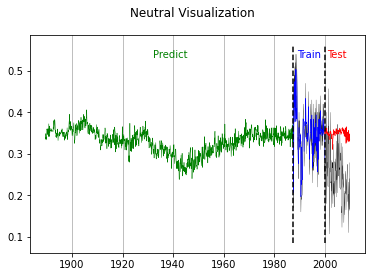

In [24]:
dates['Date'] = pd.to_datetime(dates['Date'], format='%Y%m')

fig, ax = plt.subplots(1,1)

ax.plot(dates[dates['Period'] != 'Predict']['Date'], dates[dates['Period'] != 'Predict'][target], color='black', linewidth=0.25)

ax.plot(dates[dates['Period'] == 'Predict']['Date'], dates[dates['Period'] == 'Predict']['Result'], color='green', linewidth=0.5)
ax.plot(dates[dates['Period'] == 'Train']['Date'], dates[dates['Period'] == 'Train']['Result'], color='blue', linewidth=0.5)
ax.plot(dates[dates['Period'] == 'Test']['Date'], dates[dates['Period'] == 'Test']['Result'], color='red', linewidth=0.5)

bottom = ax.get_ylim()[0]
top = ax.get_ylim()[1]

predict_mid = dates[dates['Period'] == 'Predict']['Date'].median()
train_mid = dates[dates['Period'] == 'Train']['Date'].median()
test_mid = dates[dates['Period'] == 'Test']['Date'].median()

ax.text(predict_mid, 0.95*top, 'Predict', color='green', horizontalalignment='center')
ax.text(train_mid, 0.95*top, 'Train', color='blue', horizontalalignment='center')
ax.text(test_mid, 0.95*top, 'Test', color='red', horizontalalignment='center')

ax.vlines(x=[dates[dates['Period'] == 'Train']['Date'].min(), dates[dates['Period'] == 'Train']['Date'].max()], ymin=bottom, ymax=top, color='black', linestyles='dashed')

ax.grid(axis='x')
          
fig.suptitle('%s Visualization' % target)
plt.savefig('./%s/%s_graph.pdf' % (target, target), bbox_inches='tight')